# Credit Card Fraud Detection Using Autoencoder

## Deep learning

Итак, мы добрались и до глубокого обучения. Все указанные выше классические методы были довольно требовательны: нам приходилось усердно работать с данными и параметрами самих моделей, чтобы добиться результата. Есть ли альтернатива?

### Автокодировщик

<img src="https://i0.wp.com/sefiks.com/wp-content/uploads/2018/03/autoencoder.jpeg?w=638&ssl=1" width=800>

Как видно из рисунка, автокодировщик имеет ту же архитектуру, что и обычный MLP (многослойный перцептрон), за исключением требования, чтобы количество входных нейронов было равно количеству нейронов в выходном слое. Автокодировщик во время обучения выучивает внутренние представления данных так, чтобы по входу можно было реконструировать выход. Таким образом, это означает, что автокодировщик не может просто копировать ввод в вывод, он вынужден изучать наиболее важные признаки ввода и отбрасывать остальные.

Как мы можем использовать автокодировщик для обнаружения мошеннических транзакций? Автокодировщиком мы пытаемся оптимизировать модель (то есть параметры модели), чтобы минимизировать ошибку реконструкции.

Теперь предположим, что мы подаем цифру 5 и на выходе получаем восстановленную цифру 5 с минимальной ошибкой восстановления. Теперь попробуем скормить другую цифру, которая пытается имитировать 5, когда мы получим на выходах ее восстановленную версию, она будет с большой ошибкой реконструкции. Это логика использования автокодировщика для обнаружения мошенничества. На вход подаем вектор из признаков (30 признаков).

## Declare required dependencies

In [3]:
import pandas as pd
import numpy as np
import pickle

from torch.autograd import Variable
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader


import torch.utils.data as data_utils
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams

from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42
LABELS = ["Adult", "Senior"]

## Data ingestion

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [19]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/NHANES_age_prediction.csv')

Имя переменной; Роль; Тип; Демографическое описание Единицы измерения; Отсутствующие значения:

1. SEQN	ID	Continuous		Respondent Sequence Number		no  
2. age_group	Target	Categorical	Age	Respondent's Age Group (senior/non-senior)		no  
3. RIDAGEYR	Other	Continuous	Age	Respondent's Age		no  
4. RIAGENDR	Feature	Continuous	Gender	Respondent's Gender		no  
5. PAQ605	Feature	Continuous		If the respondent engages in moderate or vigorous-intensity sports, fitness, or recreational activities in the typical week		no  
6. BMXBMI	Feature	Continuous		Respondent's Body Mass Index		no  
7. LBXGLU	Feature	Continuous		Respondent's Blood Glucose after fasting		no  
8. DIQ010	Feature	Continuous		If the Respondent is diabetic		no  
9. LBXGLT	Feature	Continuous		Respondent's Oral		no  
10. LBXIN	Feature	Continuous		Respondent's Blood Insulin Levels no


RIAGENDR: 1 представляет мужской пол, а 2 представляет женский пол.  
PAQ605: 1 означает, что респондент принимает участие в еженедельной физической активности средней или высокой интенсивности, а 2 означает, что он этого не делает.

## Data exploration

In [ ]:
df.head(5)

,SEQN,age_group,RIDAGEYR,RIAGENDR,PAQ605,BMXBMI,LBXGLU,DIQ010,LBXGLT,LBXIN
0,73564.0,Adult,61.0,2.0,2.0,35.7,110.0,2.0,150.0,14.91
1,73568.0,Adult,26.0,2.0,2.0,20.3,89.0,2.0,80.0,3.85
2,73576.0,Adult,16.0,1.0,2.0,23.2,89.0,2.0,68.0,6.14
3,73577.0,Adult,32.0,1.0,2.0,28.9,104.0,2.0,84.0,16.15
4,73580.0,Adult,38.0,2.0,1.0,35.9,103.0,2.0,81.0,10.92


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2278 entries, 0 to 2277
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   SEQN       2278 non-null   float64
 1   age_group  2278 non-null   object 
 2   RIDAGEYR   2278 non-null   float64
 3   RIAGENDR   2278 non-null   float64
 4   PAQ605     2278 non-null   float64
 5   BMXBMI     2278 non-null   float64
 6   LBXGLU     2278 non-null   float64
 7   DIQ010     2278 non-null   float64
 8   LBXGLT     2278 non-null   float64
 9   LBXIN      2278 non-null   float64
dtypes: float64(9), object(1)
memory usage: 178.1+ KB


In [ ]:
print(df.shape)
print(df.describe())

(2278, 10)
               SEQN     RIDAGEYR     RIAGENDR       PAQ605       BMXBMI  \
count   2278.000000  2278.000000  2278.000000  2278.000000  2278.000000   
mean   78691.853819    41.795874     1.511414     1.822651    27.955180   
std     2921.365151    20.156111     0.499979     0.398918     7.248962   
min    73564.000000    12.000000     1.000000     1.000000    14.500000   
25%    76171.750000    24.000000     1.000000     2.000000    22.800000   
50%    78749.000000    41.000000     2.000000     2.000000    26.800000   
75%    81213.500000    58.000000     2.000000     2.000000    31.200000   
max    83727.000000    80.000000     2.000000     7.000000    70.100000   

            LBXGLU       DIQ010       LBXGLT        LBXIN  
count  2278.000000  2278.000000  2278.000000  2278.000000  
mean     99.553117     2.016242   114.978929    11.834794  
std      17.889834     0.185556    47.061239     9.718812  
min      63.000000     1.000000    40.000000     0.140000  
25%      91.0

## Ести ли пропуски?

In [ ]:
df.isnull().values.any()

False

## Class distribution ( 0 - Adult, 1 - Senior)

In [ ]:
df['age_group'].value_counts()

,count
age_group,
Adult,1914
Senior,364


<ipython-input-589-804f49de579f>:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  count_classes = pd.value_counts(df['age_group'], sort = True)


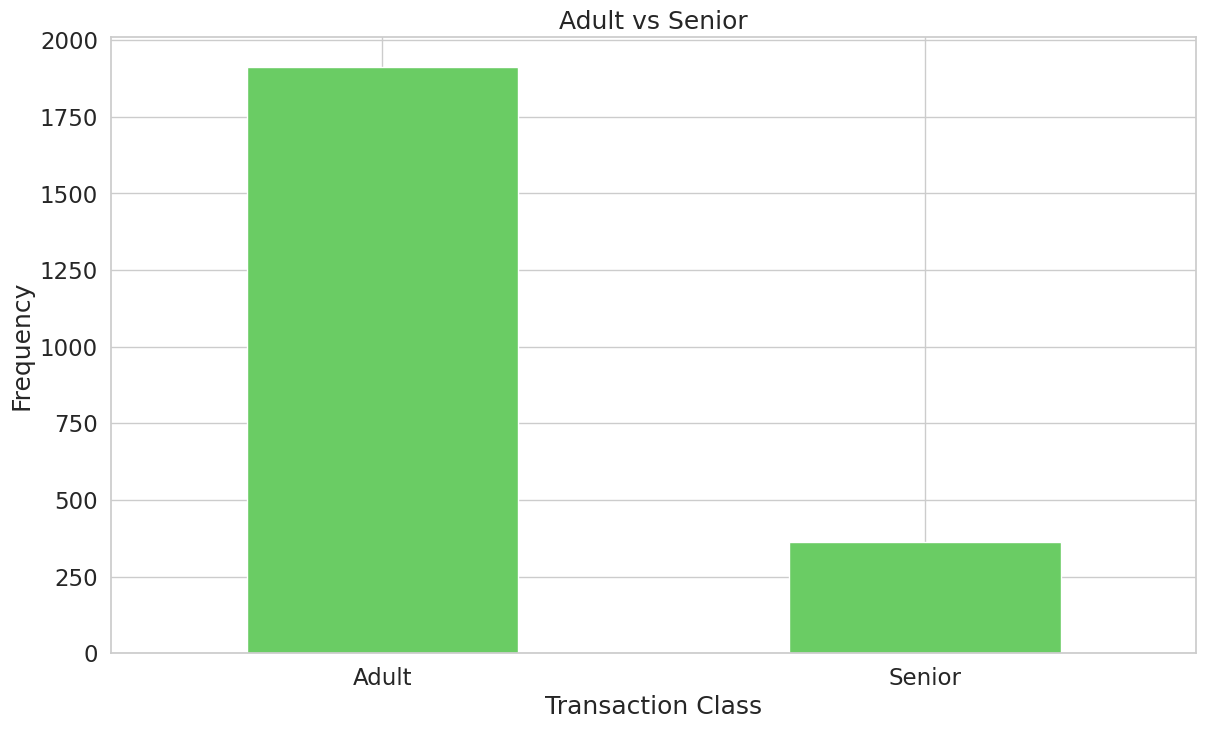

In [ ]:
count_classes = pd.value_counts(df['age_group'], sort = True)
count_classes.plot(kind = 'bar', rot=0, color="g")
plt.title("Adult vs Senior")
plt.xticks(range(2), LABELS)
plt.xlabel("Transaction Class")
plt.ylabel("Frequency");

Наш набор данных очень сильно несбалансирован в пользу отрицательного (0, то есть нормального) класса. Это требует дальнейшего изучения данных

In [121]:
# вывод на печать 'Обычные транзакции составляют' и 'Мошеннические транзакции составляют' в процентном соотношении

vc = datasets['age_group'].value_counts()  # - возвращает словарик,
# где ключ - уникальные значения в столбце Class кол-во значений
# value - сколько всего записей имело эти значения


d = 100 * vc[0] / (vc[0]+vc[1])
print(f'Adult составляют  {round(d, 3)} % данных')
print(f'Senior составляют  {round(100 - d, 3)} % данных')

Adult составляют  84.021 % данных
Senior составляют  15.979 % данных


In [20]:
df['age_group'] = df['age_group'].astype('category').cat.codes

In [21]:
Adult = df[df['age_group'] == 0]
Senior = df[df['age_group'] == 1]

In [ ]:
Senior.shape

(364, 10)

In [ ]:
Adult.shape

(1914, 10)

Посмотрим как диапозон возроста относиться к возростным группам

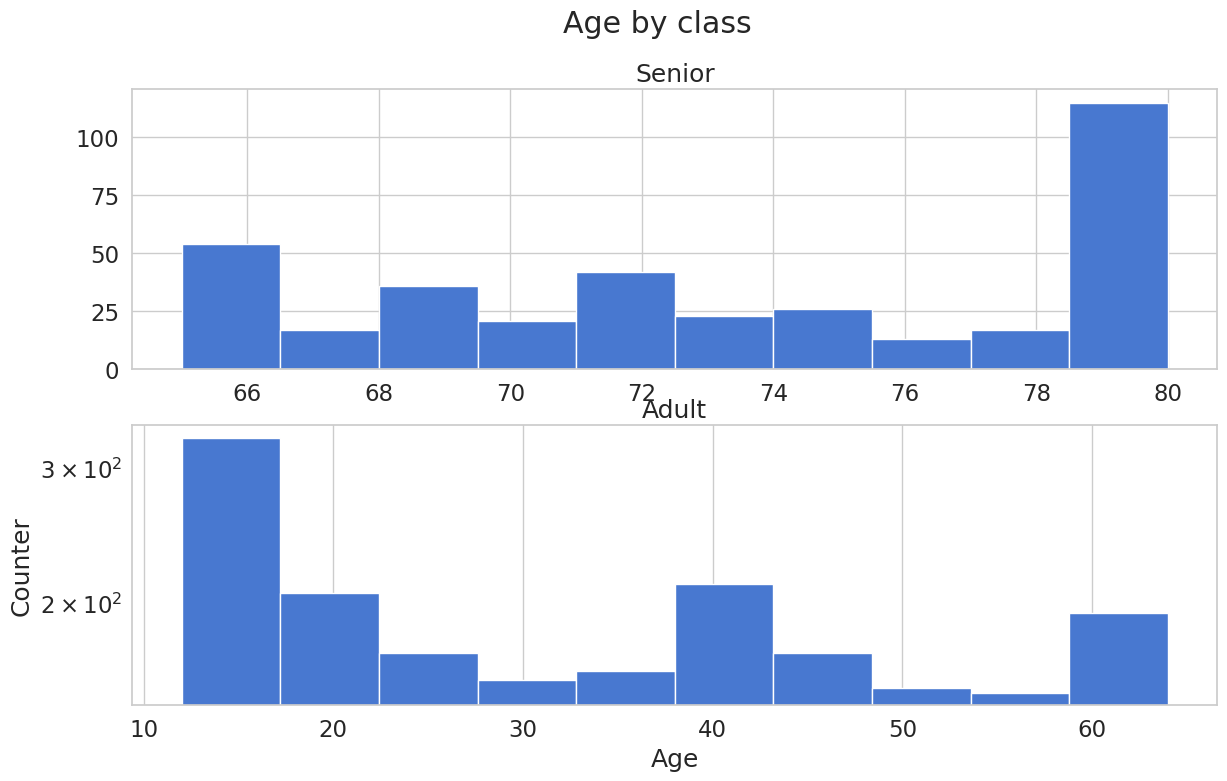

In [ ]:
f, (ax1, ax2) = plt.subplots(2, 1)
f.suptitle('Age by class')

ax1.hist(Senior.RIDAGEYR)
ax1.set_title('Senior')

ax2.hist(Adult.RIDAGEYR)
ax2.set_title('Adult')

plt.xlabel('Age')
plt.ylabel('Counter')
plt.yscale('log')
plt.show()

Влияние маcсы тела

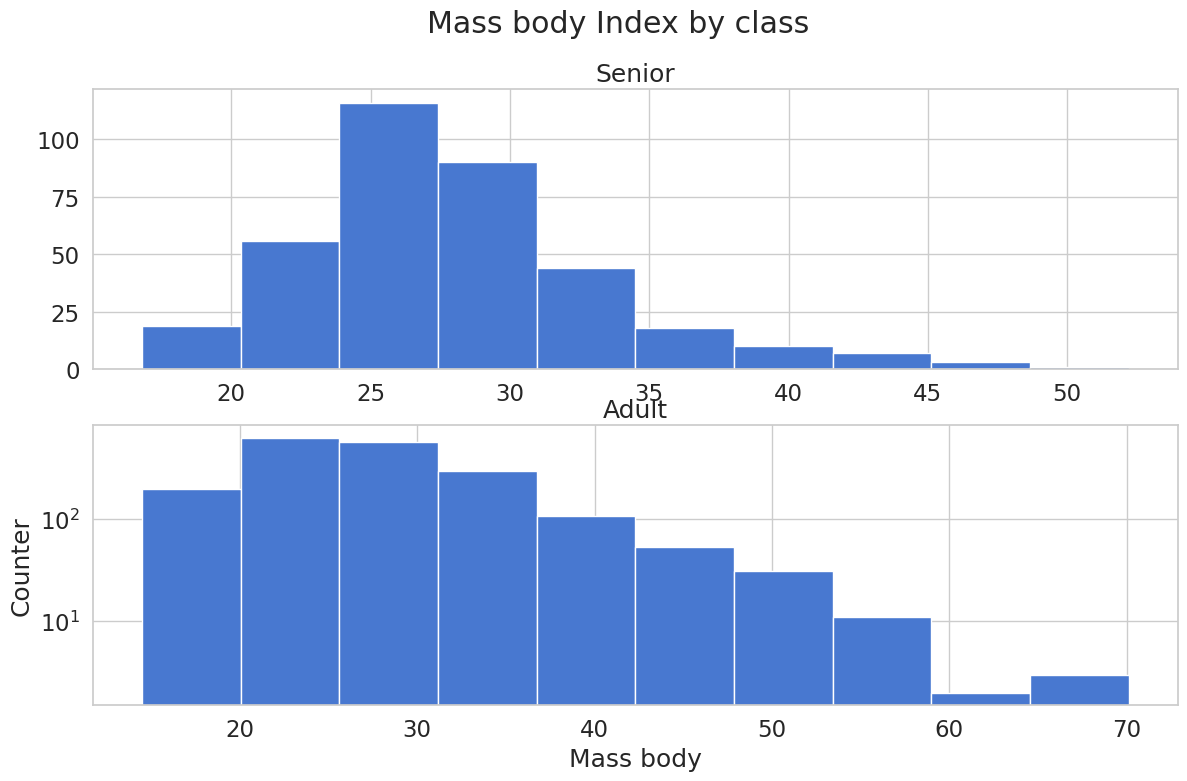

In [ ]:
f, (ax1, ax2) = plt.subplots(2, 1)
f.suptitle('Mass body Index by class')

ax1.hist(Senior.BMXBMI)
ax1.set_title('Senior')

ax2.hist(Adult.BMXBMI)
ax2.set_title('Adult')

plt.xlabel('Mass body')
plt.ylabel('Counter')
plt.yscale('log')
plt.show()

Влияет ли масса тела на уровень инсулина в крови?

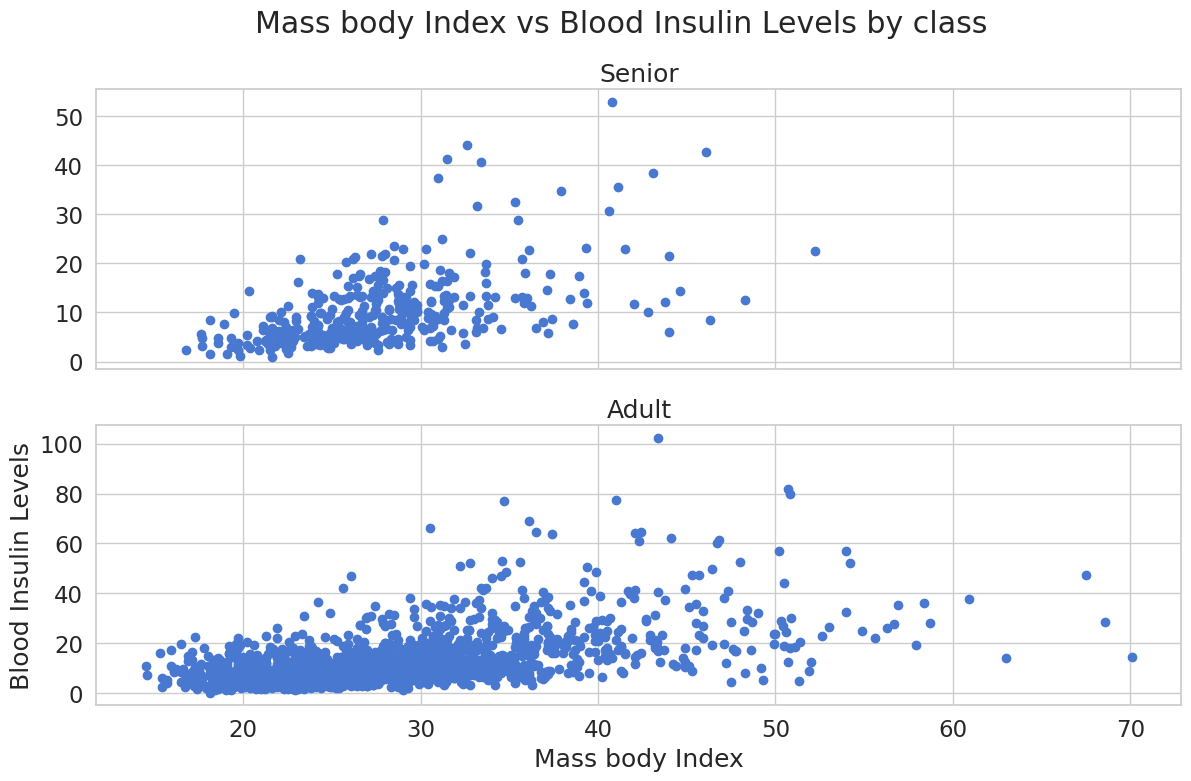

In [ ]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Mass body Index vs Blood Insulin Levels by class')

ax1.scatter(Senior.BMXBMI, Senior.LBXIN)
ax1.set_title('Senior')

ax2.scatter(Adult.BMXBMI, Adult.LBXIN)
ax2.set_title('Adult')

plt.xlabel('Mass body Index')
plt.ylabel('Blood Insulin Levels')
plt.show()

Таким образом, видно, что масса тела влияет на уровень инсулина в крови

Влияет ли масса тела на количество глюкозы в крови после еды?

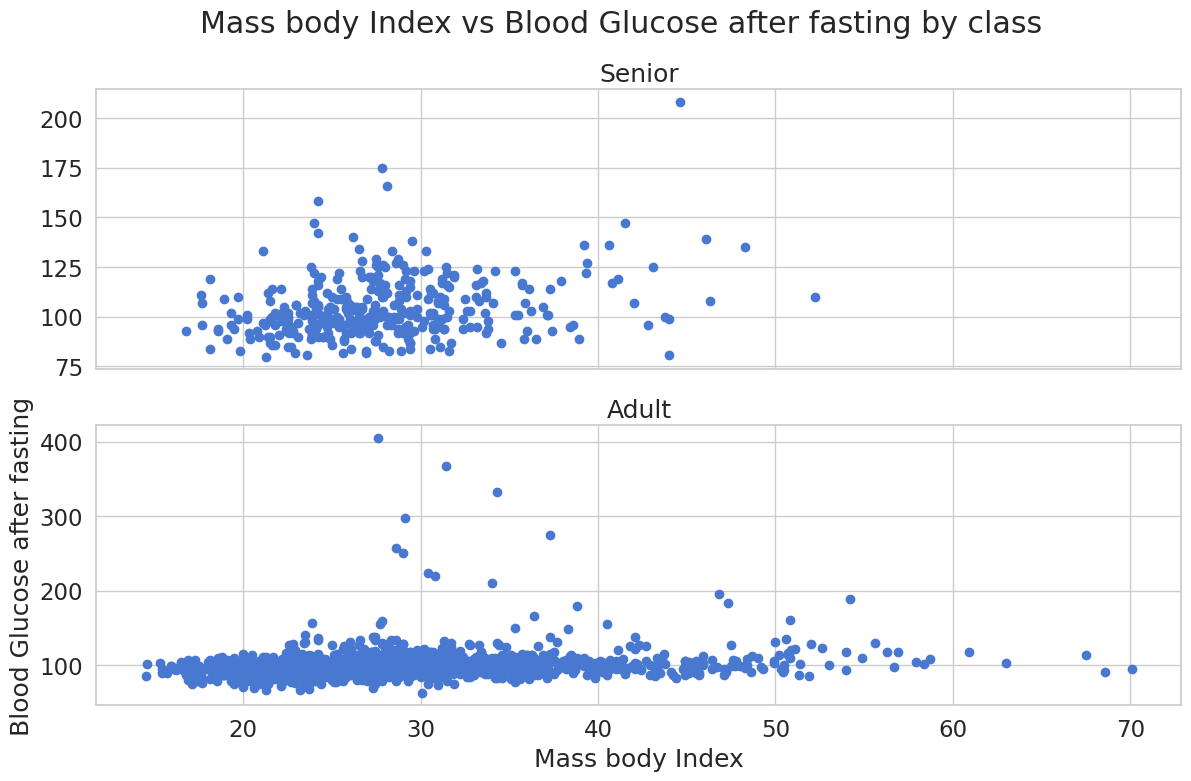

In [ ]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Blood Insulin Levels vs Blood Glucose after fasting by class')

ax1.scatter(Senior.BMXBMI, Senior.LBXGLU)
ax1.set_title('Senior')

ax2.scatter(Adult.BMXBMI, Adult.LBXGLU)
ax2.set_title('Adult')

plt.xlabel('Mass body Index')
plt.ylabel('Blood Glucose after fasting')
plt.show()

Не ясно! Надо проверить влияние уровня инсулина на количество глюкозы в крави после еды

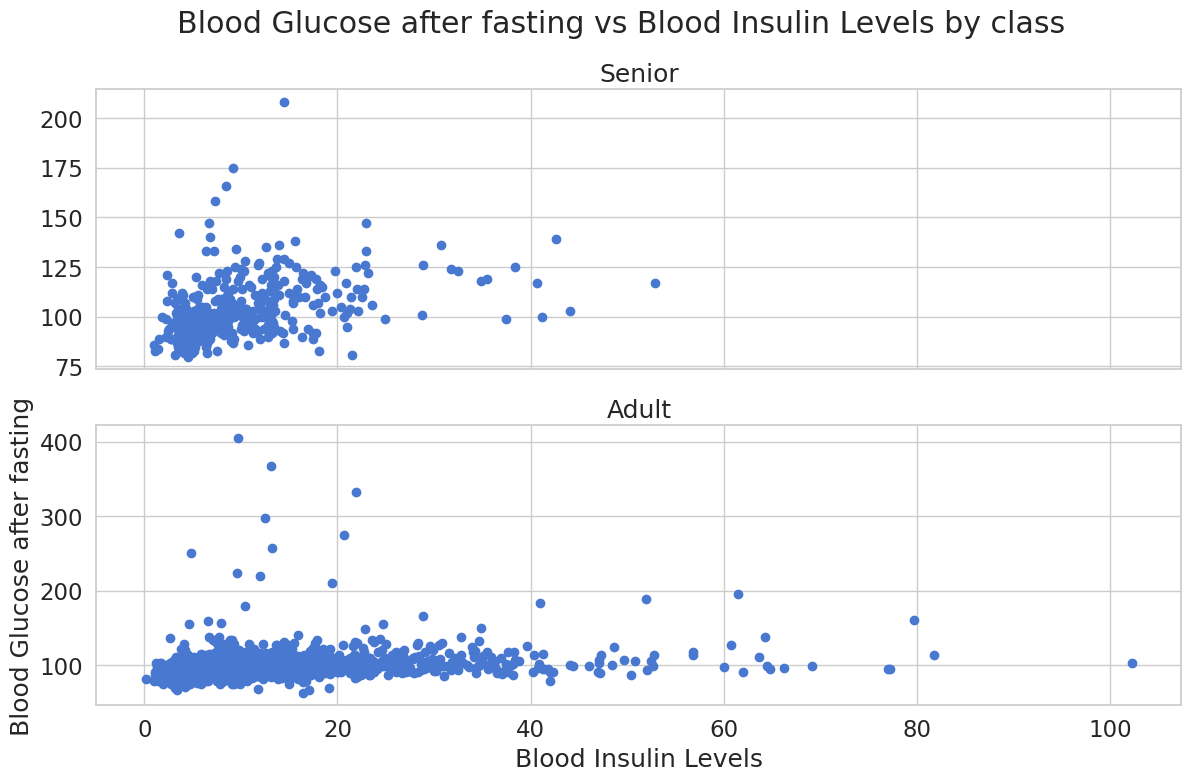

In [ ]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Blood Glucose after fasting vs Blood Insulin Levels by class')

ax1.scatter(Senior.LBXIN, Senior.LBXGLU)
ax1.set_title('Senior')

ax2.scatter(Adult.LBXIN, Adult.LBXGLU)
ax2.set_title('Adult')

plt.ylabel('Blood Glucose after fasting')
plt.xlabel('Blood Insulin Levels')
plt.show()

Видно, что зависимости есть, но сложные. Надо ещё учитывать род занятий и т.п.

## Preprocessing

Удалим ID и возраст

In [22]:
datasets = df.drop(['SEQN', 'RIDAGEYR'], axis=1)

### Разделите набор данных на наборы обучающих и тестовых данных.

Мы разделили набор данных как обучение = 70% и тест = 30%. В обучающем наборе данных будут только Adult, а в тестовом наборе данных будут оба класса.

In [23]:
from sklearn.preprocessing import MinMaxScaler

for column in datasets.columns:
  if column != 'age_group':
    datasets[column] = data=MinMaxScaler(feature_range=(0,1)).fit_transform(datasets[column].values.reshape(-1, 1))

In [ ]:
datasets.describe()

,age_group,RIAGENDR,PAQ605,BMXBMI,LBXGLU,DIQ010,LBXGLT,LBXIN
count,2278.000000,2278.000000,2278.000000,2278.000000,2278.000000,2278.000000,2278.000000,2278.000000
mean,0.159789,0.511414,0.137109,0.242000,0.106880,0.508121,0.132941,0.114486
std,0.366491,0.499979,0.066486,0.130377,0.052309,0.092778,0.083442,0.095143
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.166667,0.149281,0.081871,0.500000,0.083333,0.055996
50%,0.000000,1.000000,0.166667,0.221223,0.099415,0.500000,0.115248,0.087127
75%,0.000000,1.000000,0.166667,0.300360,0.119883,0.500000,0.159574,0.139990
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [24]:
X_train, X_test = train_test_split(datasets, test_size = 0.3, random_state=RANDOM_SEED)
X_train = X_train[X_train['age_group'] == 0]
X_train = X_train.drop(['age_group'], axis=1)
y_test = X_test['age_group']
X_test = X_test.drop(['age_group'], axis=1)

X_train = X_train.values
X_test = X_test.values
y_test = y_test.values
print(X_train.size)
print(y_test.size)

9394
684


Применим метод Random Under-Sampling, который случайным образом удаляет объекты доминирующего класса и выравнивает соотношение классов.

In [222]:
datasets = datasets.sample(frac=1)

adult_df = datasets.loc[df['age_group'] == 0][:400]
senior_df = datasets.loc[df['age_group'] == 1]

normal_distributed_df = pd.concat([adult_df, senior_df])

# Перемешивание строк датасета
new_df = normal_distributed_df.sample(frac=1, random_state=42)

new_df.head()

,age_group,RIAGENDR,PAQ605,BMXBMI,LBXGLU,DIQ010,LBXGLT,LBXIN
2205,0,1.0,0.166667,0.170863,0.081871,0.5,0.101064,0.116202
461,0,1.0,0.166667,0.325540,0.061404,0.5,0.092199,0.214391
548,1,0.0,0.166667,0.205036,0.128655,0.5,0.136525,0.149290
507,0,0.0,0.166667,0.253597,0.096491,0.5,0.046099,0.079785
883,0,0.0,0.000000,0.305755,0.140351,0.5,0.079787,0.112677


Распределение классов в подвыборке


<Axes: title={'center': 'Распределение классов \n (0: Adult || 1: Senior)'}, xlabel='age_group', ylabel='count'>

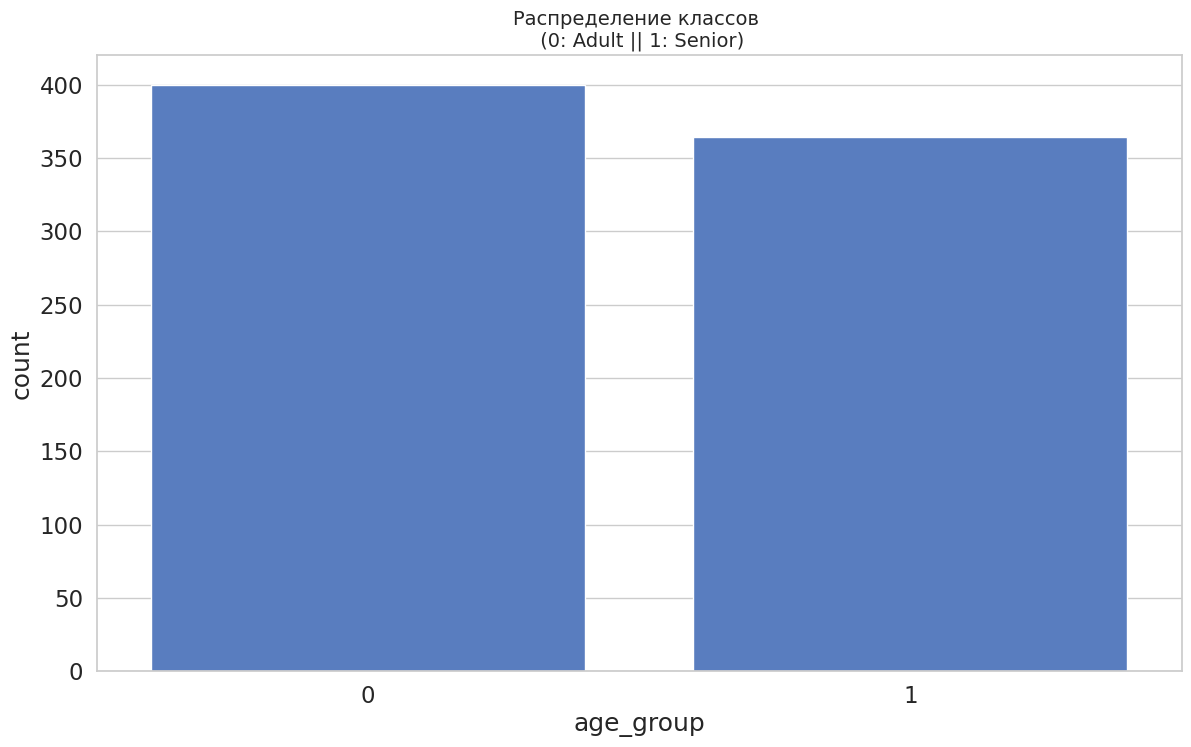

In [223]:
print('Распределение классов в подвыборке')


# проверяем снова распределение целевой переменной

plt.title('Распределение классов \n (0: Adult || 1: Senior)', fontsize=14)
sns.countplot(x=new_df['age_group'])

In [224]:
X_train, X_test = train_test_split(new_df, test_size = 0.3, random_state=RANDOM_SEED)
X_train = X_train[X_train['age_group'] == 0]
X_train = X_train.drop(['age_group'], axis=1)
y_test = X_test['age_group']
X_test = X_test.drop(['age_group'], axis=1)

X_train = X_train.values
X_test = X_test.values
y_test = y_test.values
print(X_train.size)
print(y_test.size)

1960
230


## Model
Мы построим автоэнкодер, состоящий из 4 полносвязных слоев с 4, 2, 2, 7 нейронами. Первые 2 слоя действуют как кодировщик, а последние 2 слоя действуют как декодер. Обратите внимание, что последний слой имеет 7 узлов, соответствующих 7 функциям в элементе входных данных.

In [239]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(7, 4),
            nn.Tanh(),
            nn.Linear(4, 2),
            nn.LeakyReLU(),
            )

        self.decoder = nn.Sequential(
           nn.Linear(2, 2),
           nn.Tanh(),
           nn.Linear(2, 7),
           nn.LeakyReLU()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [240]:
model = Autoencoder().double()
#model = Autoencoder().double().cpu()

In [241]:
num_epochs = 100   # сколько эпох будем обучать. Результаты обучения на одной эпохе используются как начальные для следующей.
minibatch_size = 9
learning_rate = 1e-3

**minibatch_size** - размер мини-пакета - это количество записей (или векторов), которые мы одновременно передаем в наш алгоритм обучения. Отношение между тем, насколько быстро наш алгоритм может обучить модель, обычно имеет U-образную форму (размер пакета в зависимости от скорости обучения). Это означает, что первоначально по мере увеличения размера партии время обучения будет уменьшаться. В конце концов  мы увидим, что время обучения начинает увеличиваться, когда мы превышаем определенный размер пакета, который слишком велик.
По мере увеличения размера мини-пакета большее количество вычислений означает, что градиенты могут быть более плавными, но их вычисление требует больших затрат. В идеале каждая мини-партия, на которой проводится обучение, должна содержать пример каждого класса, чтобы уменьшить ошибку выборки при оценке градиента для всей обучающей выборки.


**learning_rate** - скорость оптимизации (обучения). Насколько маленькими шашами мы изменяем градиент.

In [242]:
train_loader = data_utils.DataLoader(X_train, batch_size=minibatch_size, shuffle=True)

In [243]:
#test = data_utils.TensorDataset(torch.from_numpy(X_test).double(),torch.from_numpy(y_test).double())
#test_loader = data_utils.DataLoader(test, batch_size=minibatch_size, shuffle=True)
test_loader = data_utils.DataLoader(X_test, batch_size=1, shuffle=False)

In [244]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
model.parameters(), lr=learning_rate, weight_decay=10e-05)

In [245]:
history = {}
history['train_loss'] = []
history['test_loss'] = []

In [246]:
for epoch in range(num_epochs):
    h = np.array([])
    for data in train_loader:
        # print(type(data))
        # data = Variable(data).cpu()
        # print(type(data))
        # ===================forward=====================
        output = model(data)
        loss = criterion(output, data)
        h = np.append(h, loss.item())

        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    mean_loss = np.mean(h)
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch + 1, num_epochs, mean_loss))
    history['train_loss'].append(mean_loss)


torch.save(model.state_dict(), './model.pth')

epoch [1/100], loss:0.1303
epoch [2/100], loss:0.1094
epoch [3/100], loss:0.0931
epoch [4/100], loss:0.0812
epoch [5/100], loss:0.0717
epoch [6/100], loss:0.0612
epoch [7/100], loss:0.0535
epoch [8/100], loss:0.0451
epoch [9/100], loss:0.0373
epoch [10/100], loss:0.0309
epoch [11/100], loss:0.0259
epoch [12/100], loss:0.0210
epoch [13/100], loss:0.0176
epoch [14/100], loss:0.0151
epoch [15/100], loss:0.0130
epoch [16/100], loss:0.0115
epoch [17/100], loss:0.0104
epoch [18/100], loss:0.0098
epoch [19/100], loss:0.0092
epoch [20/100], loss:0.0088
epoch [21/100], loss:0.0092
epoch [22/100], loss:0.0083
epoch [23/100], loss:0.0083
epoch [24/100], loss:0.0082
epoch [25/100], loss:0.0081
epoch [26/100], loss:0.0085
epoch [27/100], loss:0.0081
epoch [28/100], loss:0.0082
epoch [29/100], loss:0.0082
epoch [30/100], loss:0.0082
epoch [31/100], loss:0.0082
epoch [32/100], loss:0.0081
epoch [33/100], loss:0.0081
epoch [34/100], loss:0.0081
epoch [35/100], loss:0.0081
epoch [36/100], loss:0.0083
e

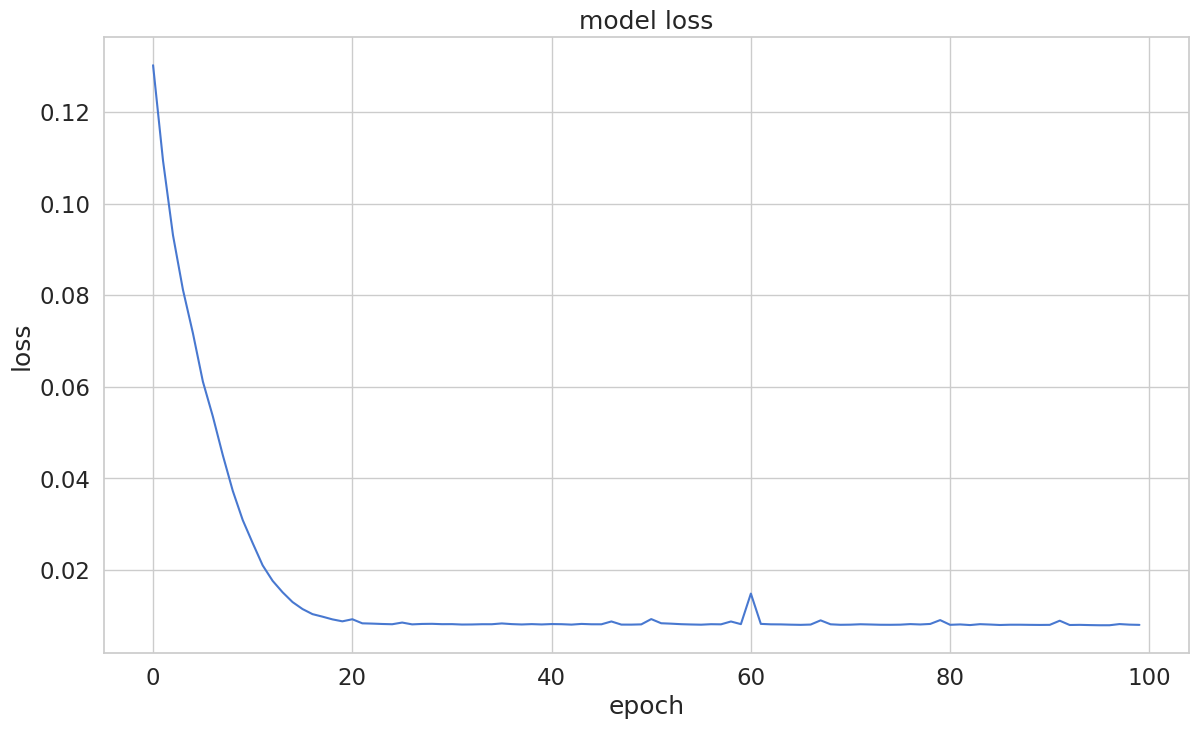

In [247]:
#history['train_loss']
#plt.plot(range(num_epochs),history['train_loss'],'ro',linewidth=2.0)
plt.plot(history['train_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
# plt.axis([0,100,0.5,0.8])
#plt.legend(['train', 'test'], loc='upper right')
plt.show()

## Оценка модели

In [248]:
pred_losses = {'pred_loss' : []}
model.eval()
with torch.no_grad():
   # test_loss = 0
    for data in test_loader:
        inputs = data
        # print(inputs)
        outputs = model(inputs)
        loss = criterion(outputs, inputs).data.item()
        #print(loss)
        pred_losses['pred_loss'].append(loss)
        #pred_losses = model([y_test.size, y_test])
reconstructionErrorDF = pd.DataFrame(pred_losses)
reconstructionErrorDF['age_group'] = y_test

In [249]:
reconstructionErrorDF.describe()

,pred_loss,age_group
count,230.000000,230.000000
mean,0.005593,0.478261
std,0.008387,0.500617
min,0.000262,0.000000
25%,0.001421,0.000000
50%,0.002995,0.000000
75%,0.005247,1.000000
max,0.047207,1.000000


# Reconstruction Errors without Senior

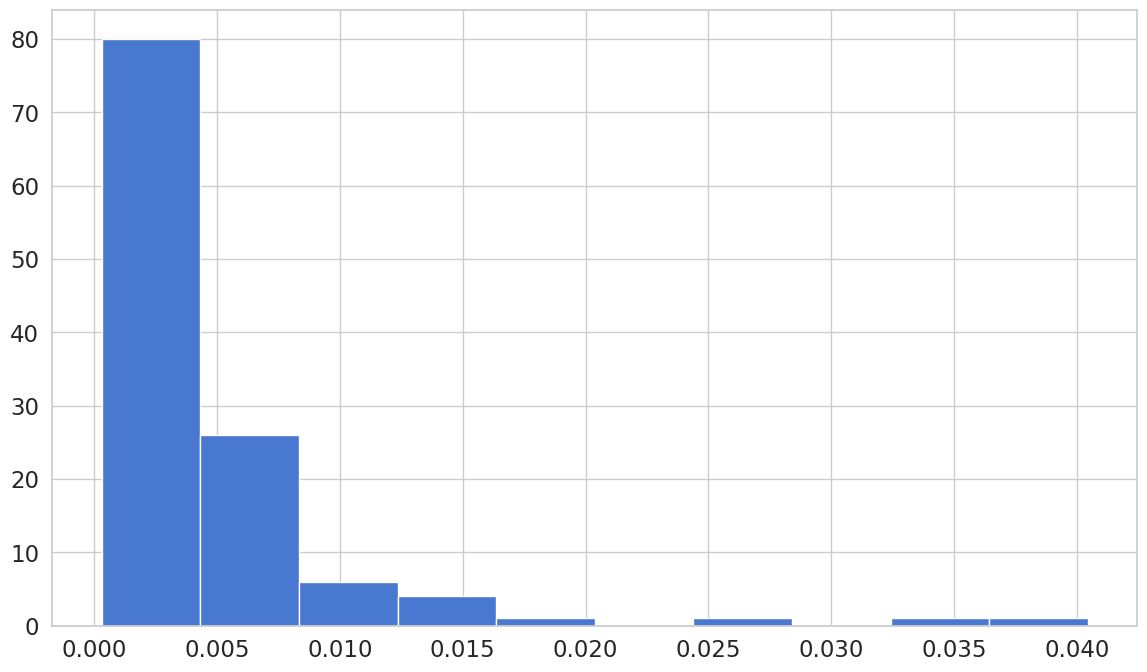

In [250]:
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = reconstructionErrorDF[(reconstructionErrorDF['age_group']== 0) & (reconstructionErrorDF['pred_loss'] < 10)]
_ = ax.hist(normal_error_df.pred_loss.values, bins=10)

# Reconstruction Errors with Senior

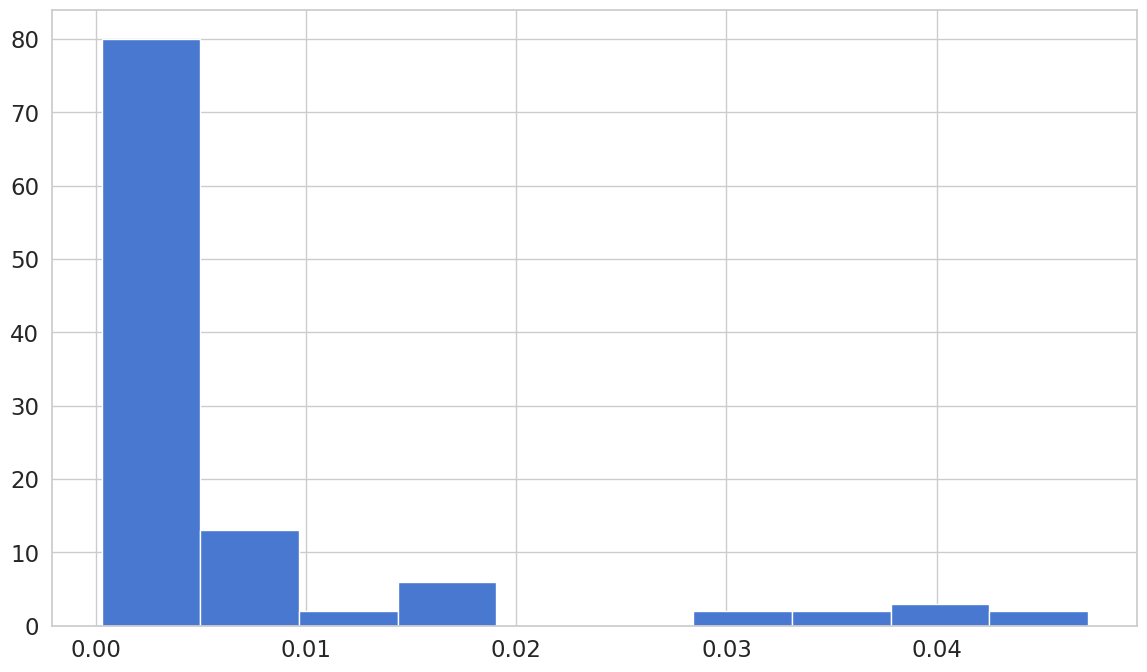

In [251]:
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = reconstructionErrorDF[(reconstructionErrorDF['age_group']== 1) ]
_ = ax.hist(fraud_error_df.pred_loss.values, bins=10)

## ROC Curves

ROC-кривая очень часто используется для анализа бинарных классификаторов. Он рассматривает все возможные пороговые значения для данного классификатора и показывает процент ложных срабатываний (FPR) по сравнению с показателями истинно положительных результатов (TPR).

Количественная интерпретация ROC даёт показатель AUC (англ. Area Under Curve, площадь под кривой) — площадь, ограниченная ROC-кривой и осью доли ложных положительных классификаций.  
Чем выше показатель AUC, тем качественнее классификатор, при этом значение 0,5 демонстрирует непригодность выбранного метода классификации (соответствует случайному гаданию).  
Значение менее 0,5 говорит, что классификатор действует с точностью до наоборот: если положительные назвать отрицательными и наоборот, классификатор будет работать лучше.

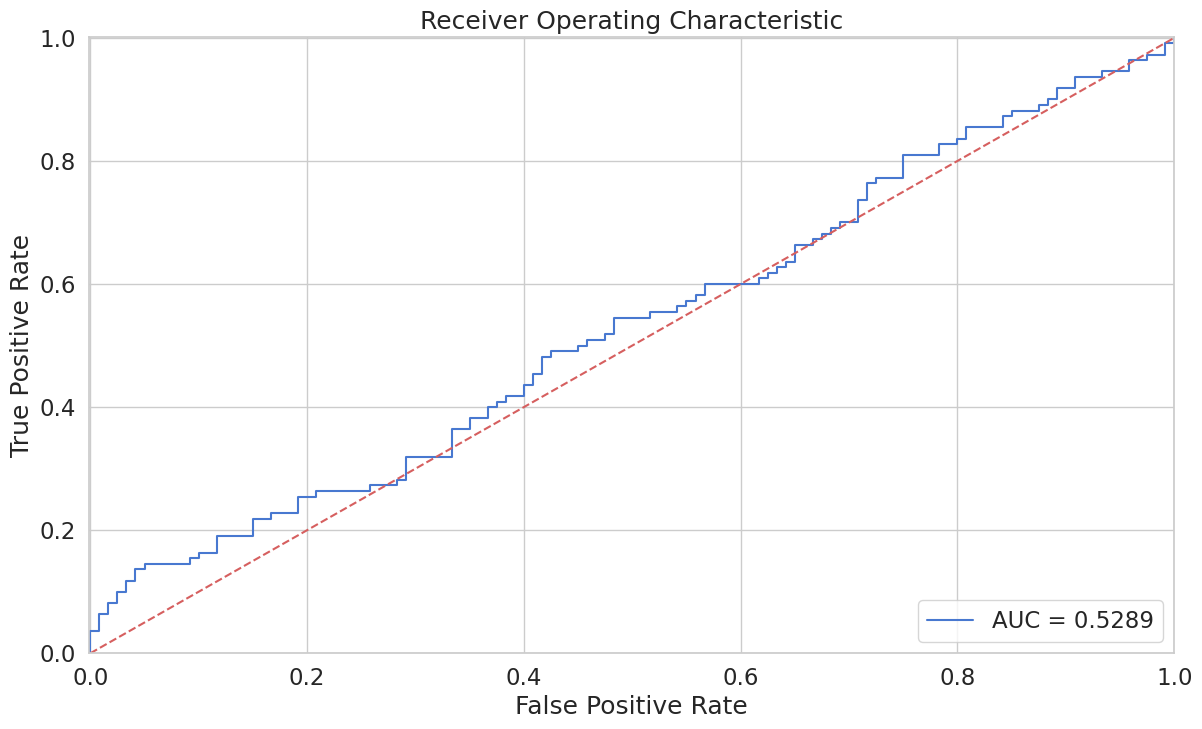

In [252]:
fpr, tpr, thresholds = roc_curve(reconstructionErrorDF['age_group'], reconstructionErrorDF.pred_loss)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

## Precision vs Recall

Установка порога, который используется для принятия решения о классификации в модели, — это способ настроить компромисс между точностью (precision) и полнотой (recall) для данного классификатора.

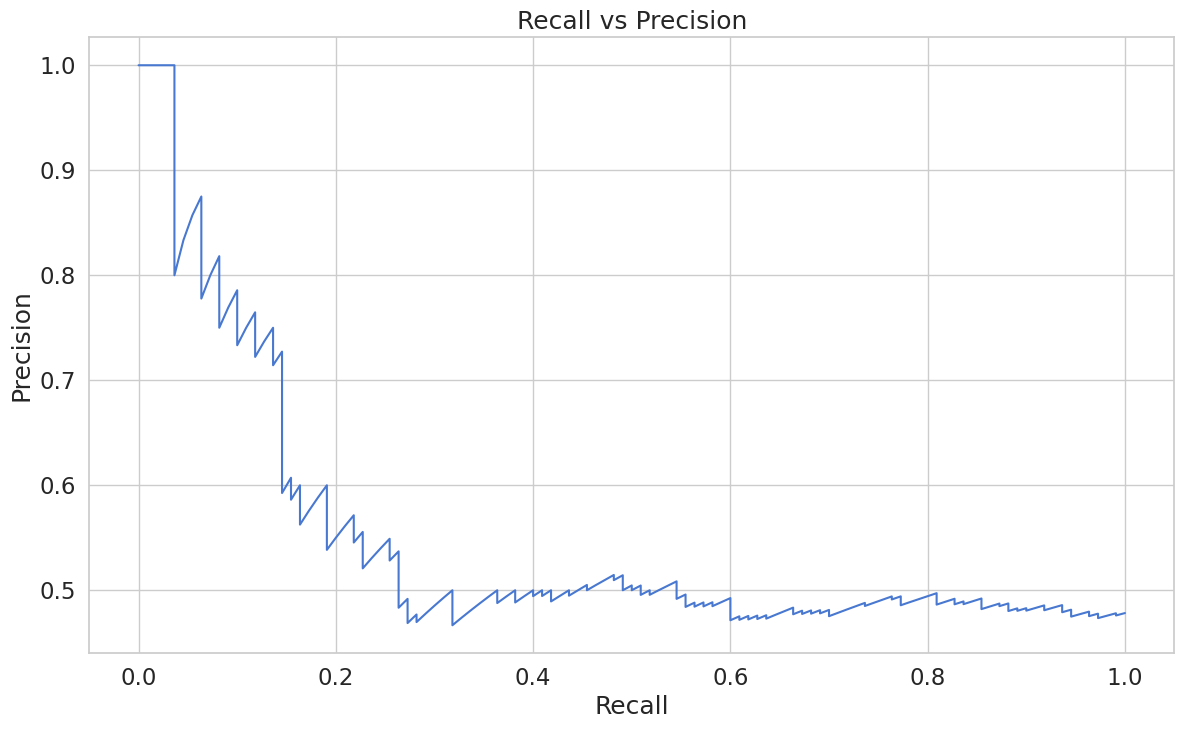

In [253]:
precision, recall, th = precision_recall_curve(reconstructionErrorDF['age_group'], reconstructionErrorDF.pred_loss)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

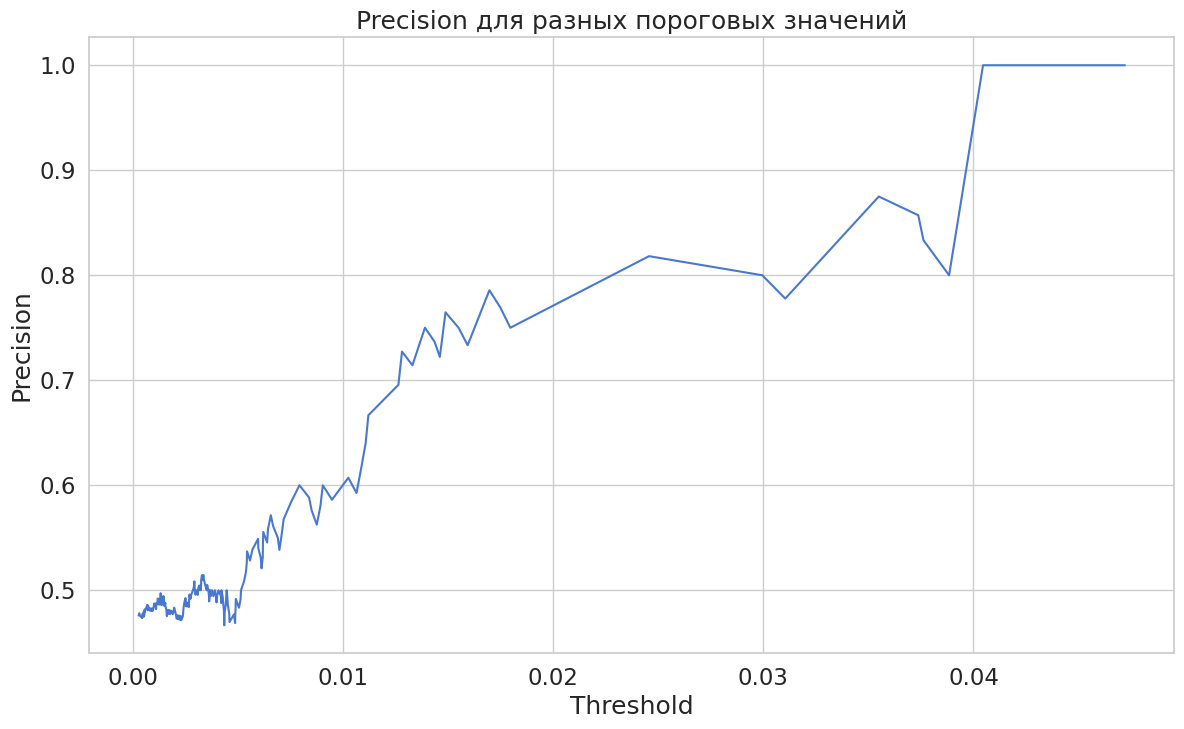

In [254]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision для разных пороговых значений')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

Вы можете видеть, что по мере увеличения ошибки реконструкции повышается и наша precision. Давайте посмотрим на recall:


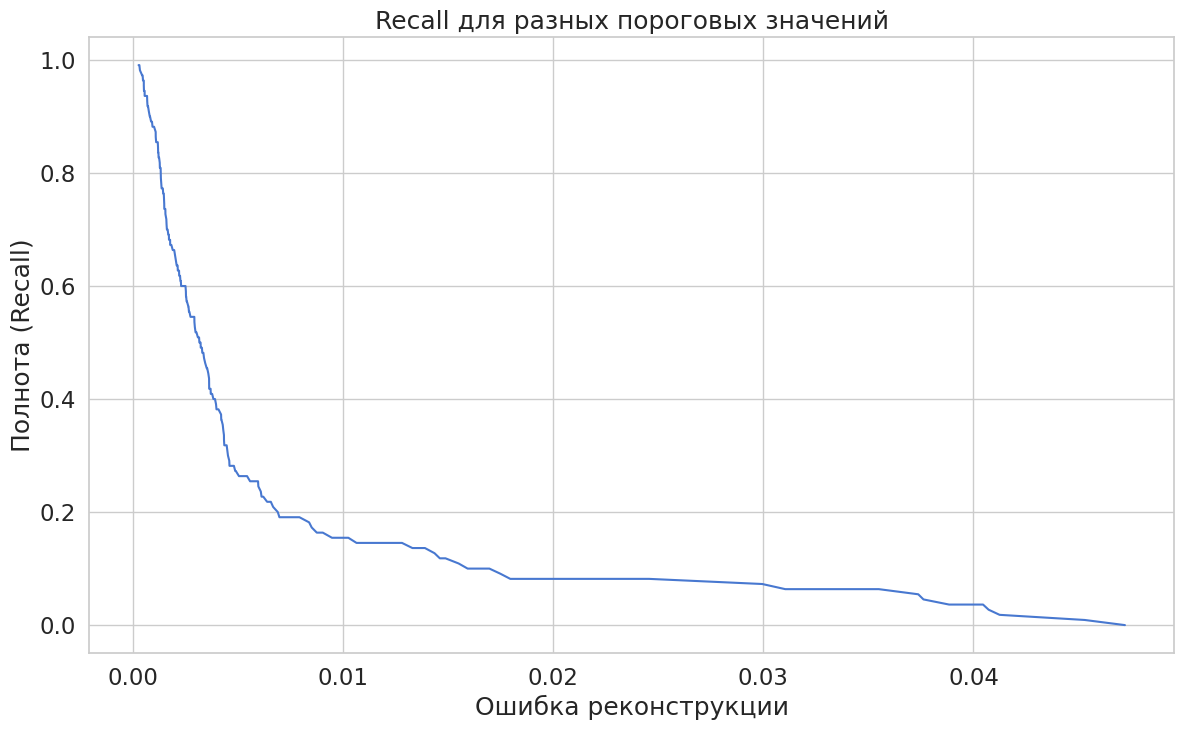

In [255]:
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall для разных пороговых значений')
plt.xlabel('Ошибка реконструкции')
plt.ylabel('Полнота (Recall)')
plt.show()

Здесь мы имеем прямо противоположную ситуацию. По мере увеличения ошибки реконструкции recall (полнота) уменьшается.

## Используем модель для того, чтобы сделать предсказание

Чтобы предсказать, является ли новая/невидимая транзакция нормальной или мошеннической, мы рассчитаем ошибку реконструкции на основе самих данных транзакции. Если ошибка превышает предопределенный порог, мы помечаем ее как мошенничество (поскольку наша модель должна иметь низкую ошибку при обычных транзакциях). Давайте выберем это значение:

In [267]:
threshold = 0.025

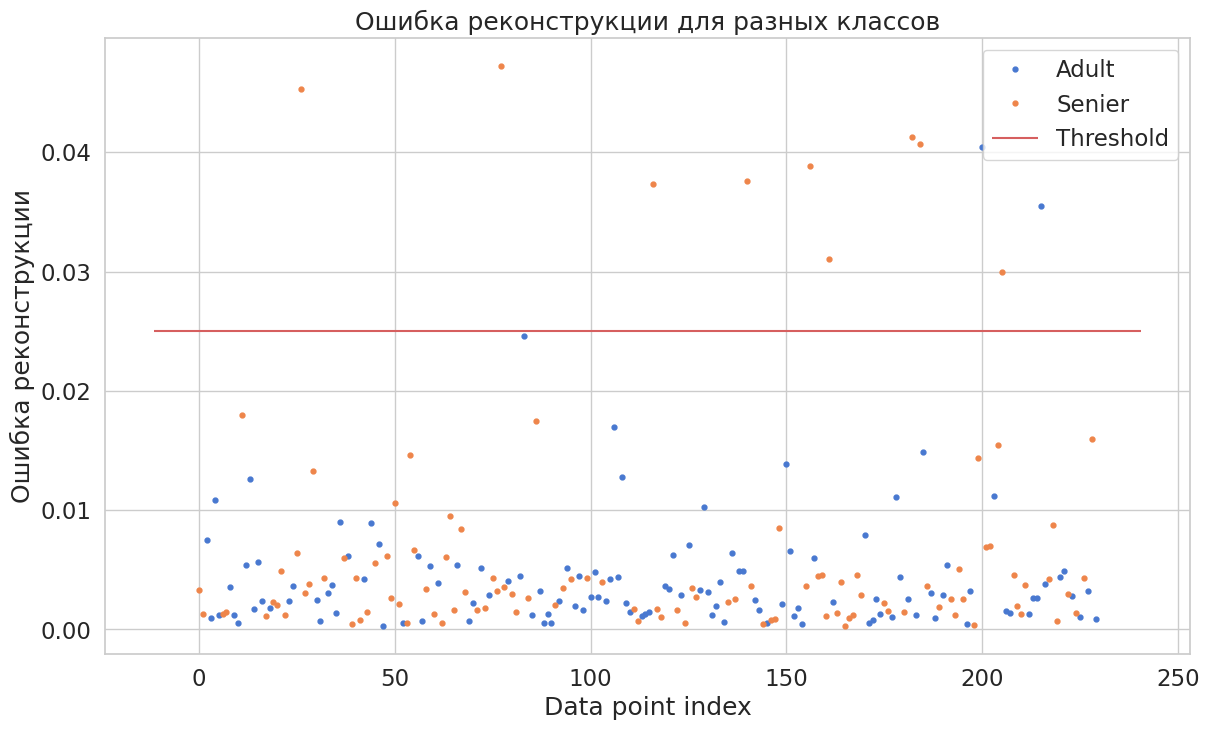

In [268]:
groups = reconstructionErrorDF.groupby('age_group')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.pred_loss, marker='o', ms=3.5, linestyle='',
            label= "Adult" if name == 0 else "Senier")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Ошибка реконструкции для разных классов")
plt.ylabel("Ошибка реконструкции")
plt.xlabel("Data point index")
plt.show();

Построим и посмотрим confusion matrix:

<ipython-input-269-3ee03242393c>:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('Blues'));


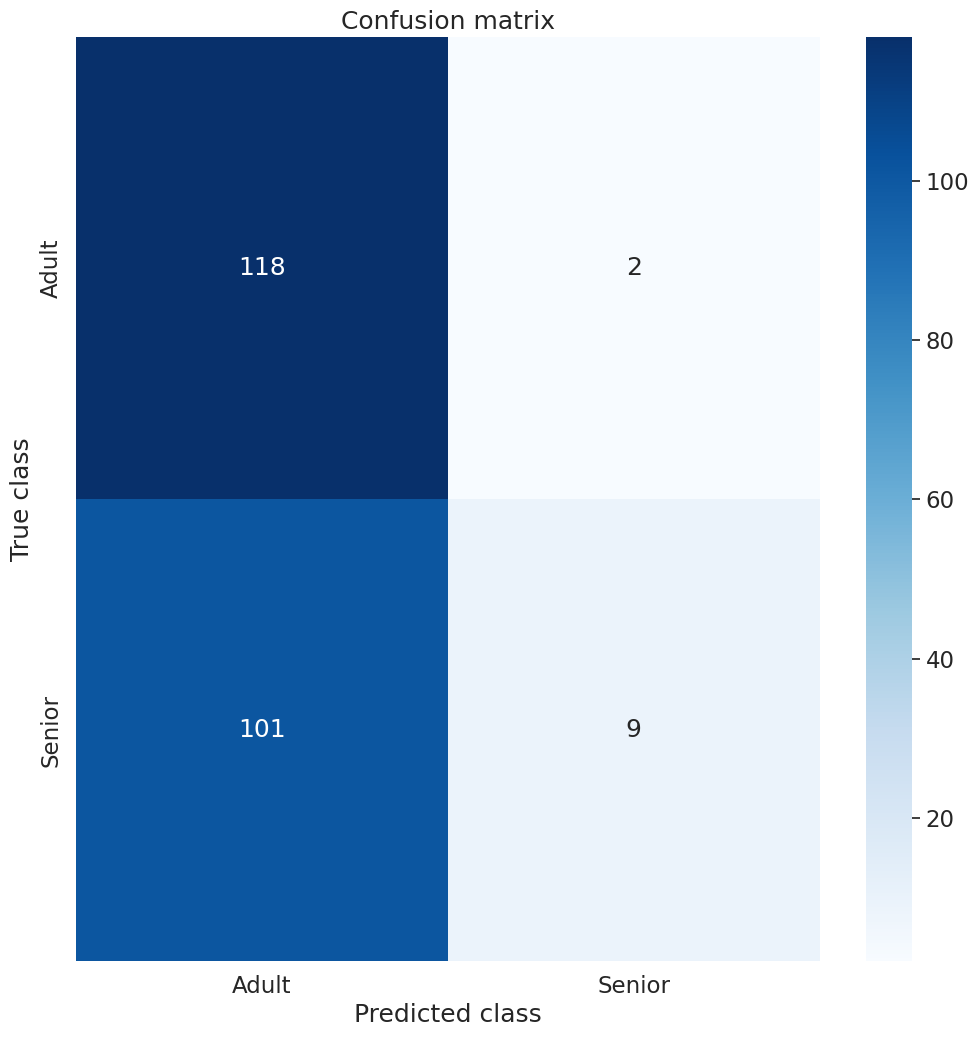

In [269]:

y_pred = [1 if e > threshold else 0 for e in reconstructionErrorDF.pred_loss.values]
conf_matrix = confusion_matrix(reconstructionErrorDF['age_group'], y_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d",
            cmap=plt.cm.get_cmap('Blues'));
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

Наша модель, похоже, выявляет множество Adult. Но количество Senior, классифицируемых как Adult, велико. Можно поработать с данными и поднастроить алгоритм.

## Выводы


Мы создали очень простой Deep Autoencoder в PyTorch, который может реконструировать, как выглядят распределение возростных групп. Он научился распознавать группы, изучая некоторые шаблоны, присутствующие в этих записях, и что это за шаблоны, о которых трудно сказать — загадка любой нейронной сети с глубоким обучением.

PyTorch предоставил нам очень понятный и простой в использовании API для создания нетривиального Deep Autoencoder. Можно попытаться создать аналогичный автоэнкодер, используя другую структуру, например Tensorflow/Keras/fast.ai, для другого домена/проблемы, например, классифицировать изображения как содержащие неприемлемый контент.